In [ ]:
pip install python-binance pandas pyarrow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.0/144.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.9 MB/s eta 0:00:00


In [ ]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
def format_binance(data):
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
               'num_trades','taker_base_volume','taker_quote_volume','ignore']
    df = pd.DataFrame(data, columns=columns)

    df['open_time']  = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms', utc=True)

    # numeric columns come in as strings
    for col in ['open','high','low','close','volume','quote_volume','taker_base_volume','taker_quote_volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


In [ ]:
# If you're in the US, the lecture notes: client = bnb_client(tld='US')
client = bnb_client(tld='US')  # or bnb_client(tld='US')

def fetch_klines(symbol: str, interval: str, start_str: str):
    raw = client.get_historical_klines(symbol, interval, start_str)
    df = format_binance(raw)
    df = df.set_index('open_time').sort_index()
    return df


In [ ]:
# --- NEW: build a bigger universe automatically ---
info = client.get_exchange_info()
symbols_info = info["symbols"]

# keep only tradable spot USDT pairs (exclude leveraged tokens etc.)
usdt_symbols = []
for s in symbols_info:
    if s["status"] != "TRADING":
        continue
    if s["quoteAsset"] != "USDT":
        continue
    if s["isSpotTradingAllowed"] is False:
        continue
    sym = s["symbol"]
    # quick filters to avoid weird/leveraged products
    if any(x in sym for x in ["UPUSDT", "DOWNUSDT", "BULLUSDT", "BEARUSDT"]):
        continue
    usdt_symbols.append(sym)

# Rank by quote volume using 24h tickers
tickers = client.get_ticker()  # list of dicts
qvol = {}
for t in tickers:
    sym = t.get("symbol")
    if sym in usdt_symbols:
        qvol[sym] = float(t.get("quoteVolume", 0.0))

# Take top N (start with 80; your 0.95 filter will keep 20–50)
univ = sorted(qvol.keys(), key=lambda x: qvol[x], reverse=True)[:80]
print("requested universe size:", len(univ))
univ[:10]



requested universe size: 80


['BTCUSDT',
 'SOLUSDT',
 'ETHUSDT',
 'XRPUSDT',
 'BNBUSDT',
 'USDCUSDT',
 'ADAUSDT',
 'DOGEUSDT',
 'HBARUSDT',
 'ZECUSDT']

In [ ]:
INTERVAL = "4h"
START = "2023-01-01"  # adjust as needed

closes = {}
volumes = {}

for sym in univ:
    try:
        df = fetch_klines(sym, INTERVAL, START)
        closes[sym] = df["close"]
        volumes[sym] = df["volume"]
        print("OK", sym, len(df))
    except Exception as e:
        print("FAIL", sym, e)

close_raw = pd.DataFrame(closes).sort_index()

min_frac = 0.90  # keep coins with >=95% price coverage
keep = close_raw.columns[close_raw.notna().mean() >= min_frac]

stable_bases = {"USDCUSDT", "FDUSDUSDT", "TUSDUSDT", "DAIUSDT", "USDPUSDT"}
keep = [c for c in keep if c not in stable_bases]

close_px = close_raw[keep].ffill().dropna()
rets = close_px.pct_change().dropna()

# volume = pd.DataFrame(volumes)[keep].reindex(close_px.index).fillna(0.0)

volume = pd.DataFrame(volumes)

# 1) Keep only the same coins as close_px
volume = volume[close_px.columns]

# 2) Align to the same timestamps as close_px
volume = volume.reindex(close_px.index)

# 3) Fill missing volumes with 0
volume = volume.fillna(0.0)

# sanity check
volume.isna().sum().sum()

print("kept assets:", len(keep))
print("close_px shape:", close_px.shape)
print("rets shape:", rets.shape)


OK BTCUSDT 6570
OK SOLUSDT 6570
OK ETHUSDT 6570
OK XRPUSDT 5404
OK BNBUSDT 6570
OK USDCUSDT 6570
OK ADAUSDT 6570
OK DOGEUSDT 6570
OK HBARUSDT 5509
OK ZECUSDT 6570
OK PEPEUSDT 2345
OK AVAXUSDT 6570
OK VETUSDT 6570
OK HYPEUSDT 1247
OK XLMUSDT 6570
OK SUIUSDT 4787
OK SHIBUSDT 6570
OK AUSDT 664
OK LINKUSDT 6570
OK IOTAUSDT 5509
OK ALGOUSDT 6570
OK DOTUSDT 6570
OK XNOUSDT 5509
OK ACHUSDT 6570
OK ONEUSDT 6570
OK LTCUSDT 6570
OK VTHOUSDT 6570
OK XDCUSDT 923
OK NEARUSDT 6570
OK FETUSDT 6570
OK ZRXUSDT 6570
OK TFUELUSDT 6570
OK CHZUSDT 6570
OK THETAUSDT 6570
OK FILUSDT 6570
OK SUSDT 1709
OK APEUSDT 6570
OK DOODUSDT 551
OK PAXGUSDT 6570
OK ATOMUSDT 6570
OK BCHUSDT 6570
OK WIFUSDT 2309
OK ZILUSDT 5509
OK DGBUSDT 6570
OK LPTUSDT 6570
OK POLUSDT 2092
OK PENGUUSDT 2093
OK ICXUSDT 5509
OK CELOUSDT 6570
OK SKYUSDT 622
OK PURRUSDT 283
OK DUSKUSDT 419
OK GALAUSDT 6570
OK RVNUSDT 5509
OK ONTUSDT 6570
OK ICPUSDT 6570
OK DASHUSDT 5509
OK XECUSDT 5794
OK PUMPUSDT 671
OK COMPUSDT 6570
OK AAVEUSDT 6570
OK ARB

In [ ]:
L = 42
mom_score = close_px / close_px.shift(L) - 1
mom_score = mom_score.reindex(rets.index)
mom_score.tail()


,BTCUSDT,SOLUSDT,ETHUSDT,BNBUSDT,ADAUSDT,DOGEUSDT,ZECUSDT,AVAXUSDT,VETUSDT,XLMUSDT,...,AAVEUSDT,QNTUSDT,AUDIOUSDT,ETCUSDT,BATUSDT,GRTUSDT,OCEANUSDT,CELRUSDT,FLOWUSDT,APTUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2025-12-30 08:00:00+00:00,0.000200,-0.006715,0.001834,0.003240,-0.037992,-0.047233,0.284684,0.019544,0.048571,-0.015200,...,-0.003048,-0.017634,0.082734,-0.009967,0.039751,-0.068063,-0.345475,0.051664,-0.470588,0.080737
2025-12-30 12:00:00+00:00,0.021143,0.013443,0.024953,0.024402,-0.020487,-0.038069,0.301325,0.046862,0.061955,-0.011096,...,-0.014282,-0.017634,-0.022727,-0.004181,0.049077,-0.027322,-0.281250,0.132344,-0.470588,0.107438
2025-12-30 16:00:00+00:00,0.006545,0.006626,0.010177,0.021141,-0.028974,-0.048125,0.286707,0.037283,0.038059,-0.028085,...,-0.022000,-0.107260,0.010204,-0.007500,0.012814,-0.060274,-0.281250,0.205304,-0.470588,0.077826
2025-12-30 20:00:00+00:00,0.012635,0.009123,0.003583,0.018502,-0.029274,-0.048090,0.272107,0.025285,0.028490,-0.027637,...,0.004323,-0.104251,-0.009967,-0.013333,0.029426,-0.041096,-0.345475,0.205304,-0.470588,0.032867
2025-12-31 00:00:00+00:00,0.014879,0.025079,0.010094,0.023015,-0.024167,-0.037820,0.279993,0.051667,0.044316,-0.019141,...,-0.003563,-0.034478,-0.020478,-0.011676,0.077535,-0.052632,-0.021059,0.163102,-0.470588,0.067913


In [ ]:
def make_long_short_weights(score: pd.DataFrame, q: float = 0.2) -> pd.DataFrame:
    w = pd.DataFrame(0.0, index=score.index, columns=score.columns)

    for t in score.index:
        s = score.loc[t].dropna()
        n = len(s)
        if n < 5:
            continue

        k = max(1, int(n * q))

        longs = s.sort_values(ascending=False).head(k).index
        shorts = s.sort_values(ascending=True).head(k).index

        w.loc[t, longs] = 1.0 / k
        w.loc[t, shorts] = -1.0 / k

    return w

w_mom = make_long_short_weights(mom_score, q=0.2)
w_mom = 0.5 * w_mom
w_mom.head()


,BTCUSDT,SOLUSDT,ETHUSDT,BNBUSDT,ADAUSDT,DOGEUSDT,ZECUSDT,AVAXUSDT,VETUSDT,XLMUSDT,...,AAVEUSDT,QNTUSDT,AUDIOUSDT,ETCUSDT,BATUSDT,GRTUSDT,OCEANUSDT,CELRUSDT,FLOWUSDT,APTUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 08:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 12:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 16:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# gross and net exposure of your weights
gross = w_mom.abs().sum(axis=1)
net = w_mom.sum(axis=1)
gross.describe(), net.describe()



(count    6569.000000
 mean        0.993759
 std         0.078762
 min         0.000000
 25%         1.000000
 50%         1.000000
 75%         1.000000
 max         1.000000
 dtype: float64,
 count    6.569000e+03
 mean     5.070283e-20
 std      7.101610e-18
 min     -5.551115e-17
 25%      0.000000e+00
 50%      0.000000e+00
 75%      0.000000e+00
 max      5.551115e-17
 dtype: float64)

In [ ]:
def backtest_unconstrained(rets: pd.DataFrame, w: pd.DataFrame, cost_bps: float = 20.0) -> pd.DataFrame:
    # Align weights to return timestamps
    w = w.reindex(rets.index).fillna(0.0)
    rebalance_every = 6  # 4H bars -> 6 per day

    mask = (np.arange(len(w)) % rebalance_every) == 0   # 1D boolean mask, length = number of rows
    w.loc[~mask, :] = np.nan                             # set NON-rebalance rows to NaN for all columns
    w = w.ffill().fillna(0.0)                            # carry last rebalance weights forward


    # Lag weights by 1 bar to avoid look-ahead bias
    w_lag = w.shift(1).fillna(0.0)

    # Gross portfolio return before costs
    gross_ret = (w_lag * rets).sum(axis=1)

    # Turnover: how much you traded to get from w_{t-1} to w_t
    turnover = (w - w_lag).abs().sum(axis=1)

    # Transaction cost in return units
    cost = turnover * (cost_bps / 10000.0)

    # Net return after costs
    net_ret = gross_ret - cost

    out = pd.DataFrame({
        "gross_ret": gross_ret,
        "turnover": turnover,
        "cost": cost,
        "net_ret": net_ret
    })

    # Equity curve starting at 1.0
    out["equity"] = (1.0 + out["net_ret"]).cumprod()

    return out

bt_mom = backtest_unconstrained(rets, w_mom, cost_bps=20)

eq_gross = (1 + bt_mom["gross_ret"]).cumprod()
eq_net   = (1 + bt_mom["net_ret"]).cumprod()

print("Final gross equity:", eq_gross.iloc[-1])
print("Final net equity:", eq_net.iloc[-1])
print("Avg turnover:", bt_mom["turnover"].mean())
print("Avg cost per bar:", bt_mom["cost"].mean())
print("Min net ret:", bt_mom["net_ret"].min())



Final gross equity: 0.017167035876772097
Final net equity: 0.003552250014111622
Avg turnover: 0.11980514537981432
Avg cost per bar: 0.0002396102907596286
Min net ret: -0.060216039057035216


In [ ]:
def perf_stats(ret: pd.Series, turnover: pd.Series, bars_per_year: int = 365 * 6) -> dict:
    ret = ret.dropna()
    mean = ret.mean()
    vol = ret.std(ddof=1)

    sharpe = np.nan
    if vol > 0:
        sharpe = (mean / vol) * np.sqrt(bars_per_year)

    equity = (1 + ret).cumprod()
    dd = equity / equity.cummax() - 1
    max_dd = dd.min()

    cagr = equity.iloc[-1] ** (bars_per_year / len(ret)) - 1

    return {
        "CAGR": cagr,
        "Vol": vol * np.sqrt(bars_per_year),
        "Sharpe": sharpe,
        "MaxDD": max_dd,
        "AvgTurnover": turnover.mean()
    }

stats_mom = perf_stats(bt_mom["net_ret"], bt_mom["turnover"])
stats_mom


{'CAGR': np.float64(-0.8474624104894324),
 'Vol': np.float64(0.3062360725941402),
 'Sharpe': np.float64(-5.984105729624295),
 'MaxDD': -0.9967681884394097,
 'AvgTurnover': np.float64(0.11980514537981432)}

In [ ]:
Ls = [6, 12, 24, 42, 84, 168]  # 1d, 2d, 4d, 7d, 14d, 28d on 4H bars

px = close_px.reindex(rets.index)  # align once to return timestamps
rows = []
bt_by_L = {}

for L in Ls:
    mom_score = px / px.shift(L) - 1

    w_mom = make_long_short_weights(mom_score, q=0.2)
    w_mom = 0.5 * w_mom  # keep gross ~ 1

    bt = backtest_unconstrained(rets, w_mom, cost_bps=20)

    stats = perf_stats(bt["net_ret"], turnover=bt["turnover"])
    stats["L"] = L
    stats["FinalEquity"] = (1 + bt["net_ret"]).cumprod().iloc[-1]
    rows.append(stats)

    bt_by_L[L] = bt

results_mom = pd.DataFrame(rows).sort_values("Sharpe", ascending=False)
results_mom


,CAGR,Vol,Sharpe,MaxDD,AvgTurnover,L,FinalEquity
5,-0.687622,0.305265,-3.657896,-0.971480,0.063666,168,0.030498
4,-0.743572,0.308986,-4.248745,-0.984809,0.087296,84,0.016872
3,-0.847462,0.306236,-5.984106,-0.996768,0.119805,42,0.003552
2,-0.904874,0.316831,-7.261905,-0.999172,0.151554,24,0.000862
1,-0.943366,0.323901,-8.695676,-0.999837,0.198491,12,0.000182
0,-0.969928,0.331632,-10.391627,-0.999973,0.272069,6,0.000027


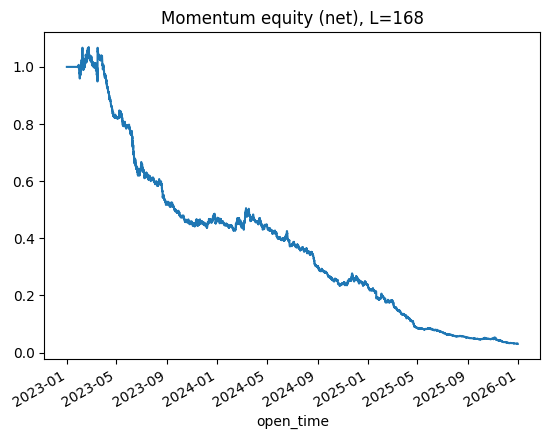

In [ ]:
best_L = int(results_mom.iloc[0]["L"])
bt_by_L[best_L]["equity"].plot(title=f"Momentum equity (net), L={best_L}")
plt.show()


In [ ]:
Hs = [1, 2, 3, 6]  # 4h, 8h, 12h, 1d

rows = []
bt_by_H = {}

for H in Hs:
    rev_score = -(rets.rolling(H).sum())

    w_rev = make_long_short_weights(rev_score, q=0.2)
    w_rev = 0.5 * w_rev

    bt = backtest_unconstrained(rets, w_rev, cost_bps=20)

    stats = perf_stats(bt["net_ret"], turnover=bt["turnover"])
    stats["H"] = H
    stats["FinalEquity"] = (1 + bt["net_ret"]).cumprod().iloc[-1]
    rows.append(stats)

    bt_by_H[H] = bt

results_rev = pd.DataFrame(rows).sort_values("Sharpe", ascending=False)
results_rev


,CAGR,Vol,Sharpe,MaxDD,AvgTurnover,H,FinalEquity
2,2.062342,0.326027,3.595908,-0.261067,0.255222,3,28.703794
3,1.669618,0.338336,3.071809,-0.226235,0.271765,6,19.017470
1,1.378375,0.331296,2.780925,-0.255719,0.256863,2,13.448364
0,0.728423,0.291809,2.020843,-0.226980,0.258690,1,5.162284


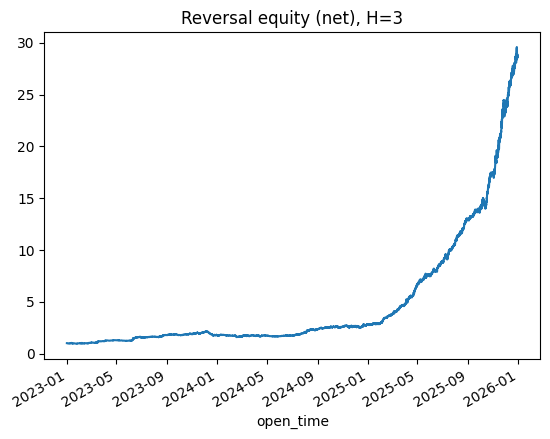

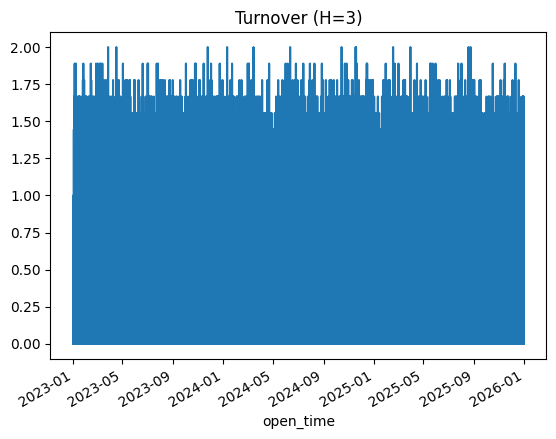

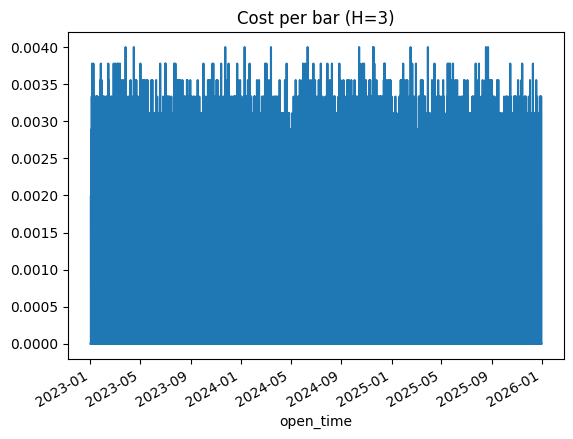

In [ ]:

# pick best H automatically from the no-filter sweep table
best_H = int(results_rev.iloc[0]["H"])

bt_best = bt_by_H[best_H]   # your dict from the sweep

bt_best["equity"].plot(title=f"Reversal equity (net), H={best_H}")
plt.show()

bt_best["turnover"].plot(title=f"Turnover (H={best_H})")
plt.show()

bt_best["cost"].plot(title=f"Cost per bar (H={best_H})")
plt.show()



In [ ]:
# No-filter stress test (20/40/60 bps) for best_H (from no-filter sweep)

best_H = int(results_rev.iloc[0]["H"])   # best from your no-filter results table
stress_costs = [20, 40, 60]
q = 0.2

rev_score = -(rets.rolling(best_H).sum())
w = 0.5 * make_long_short_weights(rev_score, q=q)   # gross ~ 1, no filter

stress_rows = []
for c in stress_costs:
    bt = backtest_unconstrained(rets, w, cost_bps=c)

    s = perf_stats(bt["net_ret"], turnover=bt["turnover"])   # dict
    s["H"] = best_H
    s["cost_bps"] = c
    s["FinalEquity"] = (1 + bt["net_ret"]).cumprod().iloc[-1]
    s["AvgTurnover"] = bt["turnover"].mean()
    s["AvgCostPerBar"] = bt["cost"].mean()

    stress_rows.append(s)

stress_no_filter = (
    pd.DataFrame(stress_rows)
      .loc[:, ["H","cost_bps","CAGR","Vol","Sharpe","MaxDD","AvgTurnover","FinalEquity","AvgCostPerBar"]]
      .sort_values("cost_bps")
      .reset_index(drop=True)
)

stress_no_filter



,H,cost_bps,CAGR,Vol,Sharpe,MaxDD,AvgTurnover,FinalEquity,AvgCostPerBar
0,3,20,2.062342,0.326027,3.595908,-0.261067,0.255222,28.703794,0.000510
1,3,40,-0.003789,0.342076,0.159290,-0.727987,0.255222,0.988677,0.001021
2,3,60,-0.677064,0.365471,-2.909630,-0.974159,0.255222,0.033696,0.001531


In [ ]:
# Pick best_H from your sweep results (choose metric: Sharpe or FinalEquity)
best_H = int(results_rev.sort_values("Sharpe", ascending=False).iloc[0]["H"])
# best_H = int(results_rev.sort_values("FinalEquity", ascending=False).iloc[0]["H"])  # alternative

cut = "2024-01-01"
bt = bt_by_H[best_H]

train = bt.loc[bt.index < cut]
test  = bt.loc[bt.index >= cut]

train_stats = perf_stats(train["net_ret"], train["turnover"])
test_stats  = perf_stats(test["net_ret"],  test["turnover"])

train_test = (
    pd.DataFrame([train_stats, test_stats], index=[f"Train (< {cut})", f"Test (>= {cut})"])
    [["Sharpe", "CAGR", "Vol", "MaxDD", "AvgTurnover"]]
    .round(3)
)

print("best_H =", best_H)
train_test


best_H = 3


,Sharpe,CAGR,Vol,MaxDD,AvgTurnover
Train (< 2024-01-01),2.010,0.765,0.305,-0.190,0.257
Test (>= 2024-01-01),4.323,3.033,0.336,-0.134,0.254


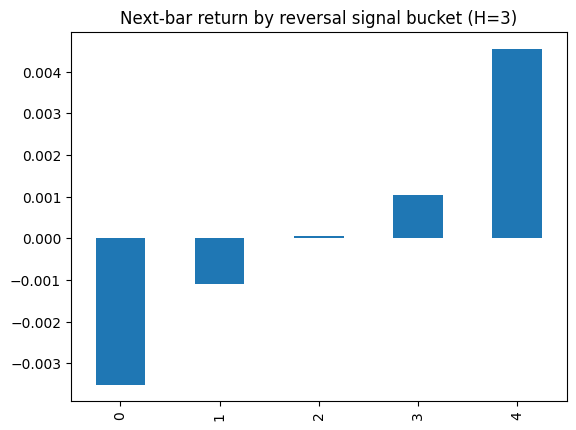

0   -0.003510
1   -0.001103
2    0.000063
3    0.001040
4    0.004555
dtype: float64


In [ ]:
# Use the same best_H chosen above
H = best_H

signal = -(rets.rolling(H).sum()).dropna()
future_ret = rets.shift(-1).loc[signal.index]  # next bar return aligned

# Rank into 5 buckets each timestamp (0..4)
q_rank = signal.rank(axis=1, pct=True)
bucket = (q_rank * 5).astype(int).clip(0, 4)

bucket_mean = {}
for b in range(5):
    mask = (bucket == b)
    bucket_mean[b] = future_ret.where(mask).mean(axis=1)

bucket_df = pd.DataFrame(bucket_mean)

# Plot + print the 5 bucket means (these are what your report wants)
bucket_df.mean().plot(kind="bar", title=f"Next-bar return by reversal signal bucket (H={H})")
plt.show()

print(bucket_df.mean())


In [ ]:
t = signal.index[200]
pd.DataFrame({"signal": signal.loc[t], "q": q.loc[t], "bucket": bucket.loc[t]}).sort_values("signal")


,signal,q,bucket
FETUSDT,-0.162864,0.021739,0
ONEUSDT,-0.115178,0.043478,0
ACHUSDT,-0.081317,0.065217,0
CELRUSDT,-0.075610,0.086957,0
FLOWUSDT,-0.054097,0.108696,0
OCEANUSDT,-0.047888,0.130435,0
LPTUSDT,-0.043910,0.152174,0
CELOUSDT,-0.038950,0.173913,0
DOTUSDT,-0.030541,0.195652,0
AUDIOUSDT,-0.028332,0.217391,1


In [ ]:
def make_long_short_weights_masked(score: pd.DataFrame, tradable: pd.DataFrame, q: float = 0.2) -> pd.DataFrame:
    w = pd.DataFrame(0.0, index=score.index, columns=score.columns)

    for t in score.index:
        s = score.loc[t]

        # keep only tradable (liquid) coins at time t
        s = s[tradable.loc[t]]
        s = s.dropna()
        n = len(s)

        if n < 5:
            continue

        k = max(1, int(n * q))

        longs = s.sort_values(ascending=False).head(k).index
        shorts = s.sort_values(ascending=True).head(k).index

        # equal-weight longs and shorts
        w.loc[t, longs] =  1.0 / k
        w.loc[t, shorts] = -1.0 / k

    return w


In [ ]:
# -----------------------------
# Config
# -----------------------------
Hs = [1, 2, 3, 6]
q = 0.2
vol_cut = 0.5          # keep top 50% volume each bar
base_cost_bps = 20

# Align volume to rets (important for filter correctness)
volume_aligned = volume.reindex(index=rets.index, columns=rets.columns).fillna(0.0)
vol_rank = volume_aligned.rank(axis=1, pct=True)

tradable = vol_rank >= vol_cut  # boolean DataFrame

rows_liq = []
bt_by_H_liq = {}

for H in Hs:
    rev_score = -(rets.rolling(H).sum())

    w = make_long_short_weights_masked(rev_score, tradable=tradable, q=q)

    # scale gross ~1 (because base gross is 2: +1 and -1)
    w = 0.5 * w

    avg_gross = w.abs().sum(axis=1).mean()
    print(f"H={H} avg gross exposure: {avg_gross:.3f}")

    bt = backtest_unconstrained(rets, w, cost_bps=base_cost_bps)

    stats = perf_stats(bt["net_ret"], turnover=bt["turnover"])
    stats["H"] = H
    stats["FinalEquity"] = (1 + bt["net_ret"]).cumprod().iloc[-1]
    stats["AvgCostPerBar"] = bt["cost"].mean()
    stats["AvgGrossRet"] = bt["gross_ret"].mean()
    stats["AvgTurnover"] = bt["turnover"].mean()

    rows_liq.append(stats)
    bt_by_H_liq[H] = bt

results_rev_liq = pd.DataFrame(rows_liq).sort_values("Sharpe", ascending=False)
results_rev_liq

cols = ["CAGR", "Vol", "Sharpe", "MaxDD", "AvgTurnover", "H", "FinalEquity"]
results_rev_liq[cols]

H=1 avg gross exposure: 1.000
H=2 avg gross exposure: 1.000
H=3 avg gross exposure: 1.000
H=6 avg gross exposure: 0.999


,CAGR,Vol,Sharpe,MaxDD,AvgTurnover,H,FinalEquity
2,1.294391,0.445846,2.086009,-0.366244,0.279228,3,12.073625
1,0.765649,0.448040,1.492498,-0.360680,0.279723,2,5.503012
0,0.755279,0.457007,1.457460,-0.388450,0.283529,1,5.406636
3,0.361651,0.473715,0.886483,-0.462364,0.286497,6,2.524275


Best H (liq): 3
Final equity (liq): 12.073625201215743
Avg turnover (liq): 0.2792281930278581


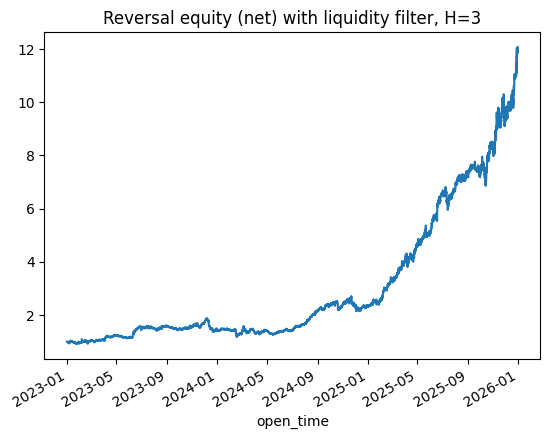

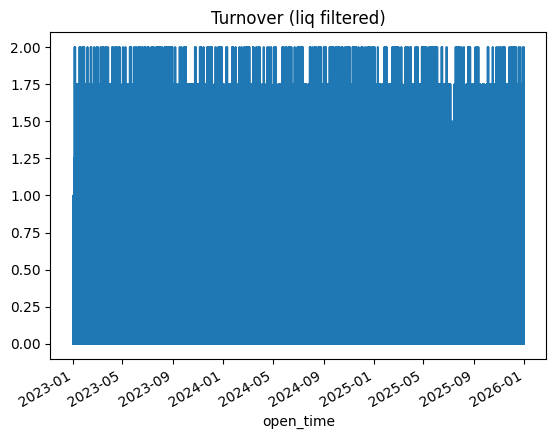

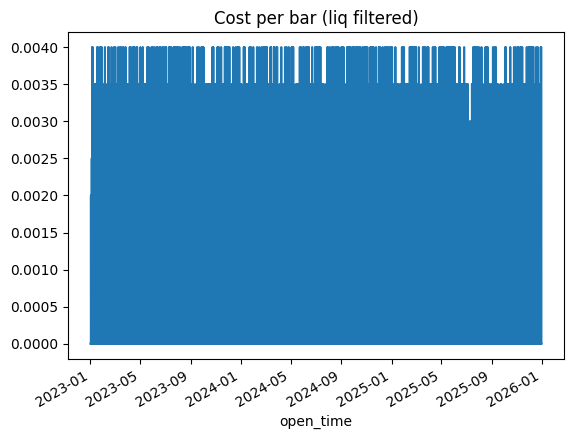

In [ ]:
# -----------------------------
# 2) Pick best H from liquidity-filtered sweep + plot
# -----------------------------
best_H_liq = int(results_rev_liq.iloc[0]["H"])
bt_best_liq = bt_by_H_liq[best_H_liq]

print("Best H (liq):", best_H_liq)
print("Final equity (liq):", bt_best_liq["equity"].iloc[-1])
print("Avg turnover (liq):", bt_best_liq["turnover"].mean())

bt_best_liq["equity"].plot(title=f"Reversal equity (net) with liquidity filter, H={best_H_liq}")
plt.show()

bt_best_liq["turnover"].plot(title="Turnover (liq filtered)")
plt.show()

bt_best_liq["cost"].plot(title="Cost per bar (liq filtered)")
plt.show()


In [ ]:
# -----------------------------
# 3) Liquidity-filtered stress test (20/40/60 bps) for best_H_liq
# -----------------------------
rev_score = -(rets.rolling(best_H_liq).sum())
w = 0.5 * make_long_short_weights(rev_score, q=q)
w = w.where(vol_rank >= vol_cut, 0.0)

stress_rows = []
for c in stress_costs:
    bt = backtest_unconstrained(rets, w, cost_bps=c)
    s = perf_stats(bt["net_ret"], turnover=bt["turnover"])
    s["H"] = best_H_liq
    s["cost_bps"] = c
    s["FinalEquity"] = (1 + bt["net_ret"]).cumprod().iloc[-1]
    s["AvgTurnover"] = bt["turnover"].mean()
    s["AvgCostPerBar"] = bt["cost"].mean()
    stress_rows.append(s)

stress_liq = pd.DataFrame(stress_rows).sort_values("cost_bps")
stress_liq

# enforce exact column order (only keep columns that exist)
col_order = ["H", "cost_bps", "CAGR", "Vol", "Sharpe", "MaxDD", "AvgTurnover", "FinalEquity", "AvgCostPerBar"]
stress_liq = stress_liq[[c for c in col_order if c in stress_liq.columns]]

# optional: nice rounding for display
stress_liq = stress_liq.round({
    "CAGR": 6, "Vol": 6, "Sharpe": 6, "MaxDD": 6,
    "AvgTurnover": 6, "FinalEquity": 6, "AvgCostPerBar": 6
})

stress_liq


,H,cost_bps,CAGR,Vol,Sharpe,MaxDD,AvgTurnover,FinalEquity,AvgCostPerBar
0,3,20,0.257182,0.245919,1.053680,-0.235882,0.143409,1.986778,0.000287
1,3,40,-0.330215,0.251971,-1.464508,-0.735612,0.143409,0.300529,0.000574
2,3,60,-0.643564,0.261508,-3.813059,-0.957225,0.143409,0.045305,0.000860
